In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
X_train[0] #pixel values. The actual image is black and white, so one color channel. We're just applying a weird color map

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

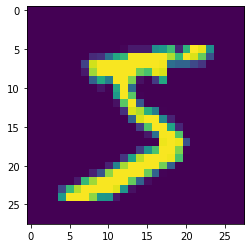

In [5]:
plt.imshow(X_train[0])

In [6]:
y_train # y_train[0] shows a five, straight up saying what number it is

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [7]:
X_train = X_train/255
X_train = X_train.reshape(-1,28,28,1) * 2. - 1. #scaling data

In [8]:
X_train.min()

-1.0

In [9]:
only_zeroes = X_train[y_train==0] #only collects the images from X_train that are zeroes

In [10]:
only_zeroes.shape #5923 imgs, 28x28 shape.

(5923, 28, 28, 1)

In [11]:
X_train.shape

(60000, 28, 28, 1)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout,LeakyReLU,BatchNormalization,Conv2D,Conv2DTranspose #dont need to work bout conv or pool layers, aint a DCGAN
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
discriminator = Sequential()

discriminator.add(Conv2D(64,kernel_size=5,strides=2,padding="same",
                         activation=LeakyReLU(0.3),
                         input_shape=[28,28,1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128,kernel_size=5,strides=2,padding="same",
                         activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation="sigmoid"))

In [14]:
#coding_size should be less than 28*28 = 784
codings_size = 100

In [15]:
generator =  Sequential()
generator.add(Dense(7*7*128,activation='relu',input_shape=[codings_size]))
generator.add(Reshape([7,7,128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64,kernel_size=5,strides=2,padding="same",
                            activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1,kernel_size=5,strides=2,padding="same",
                              activation="relu"))

#don't compile at all. We want it to be impossible to train unless we train through GAN. obviously, if we don't compile we cannot train it.

In [16]:
GAN = Sequential([generator,discriminator])

In [17]:
discriminator.compile(loss="binary_crossentropy",optimizer="adam")
discriminator.trainable = False

In [18]:
GAN.compile(loss='binary_crossentropy',optimizer='adam',)

In [19]:
batch_size = 32

In [20]:
my_data = only_zeroes
# or: my_data = X_train

In [21]:
my_data.shape

(5923, 28, 28, 1)

In [22]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [23]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [24]:
batch_size=50

In [25]:
dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1) #ignore leftover images

In [26]:
epochs = 20

In [27]:
GAN

In [28]:
GAN.layers #the two models within(generator, discriminator)

In [29]:
GAN.layers[0].layers #layers of generator

In [30]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [31]:
# Grab the seperate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")   

Currently on Epoch 1
	Currently on batch number 100 of 118
Currently on Epoch 2
	Currently on batch number 100 of 118
Currently on Epoch 3
	Currently on batch number 100 of 118
Currently on Epoch 4
	Currently on batch number 100 of 118
Currently on Epoch 5
	Currently on batch number 100 of 118
Currently on Epoch 6
	Currently on batch number 100 of 118
Currently on Epoch 7
	Currently on batch number 100 of 118
Currently on Epoch 8
	Currently on batch number 100 of 118
Currently on Epoch 9
	Currently on batch number 100 of 118
Currently on Epoch 10
	Currently on batch number 100 of 118
Currently on Epoch 11
	Currently on batch number 100 of 118
Currently on Epoch 12
	Currently on batch number 100 of 118
Currently on Epoch 13
	Currently on batch number 100 of 118
Currently on Epoch 14
	Currently on batch number 100 of 118
Currently on Epoch 15
	Currently on batch number 100 of 118
Currently on Epoch 16
	Currently on batch number 100 of 118
Currently on Epoch 17
	Currently on batch number 

In [32]:
noise = tf.random.normal(shape=[10,codings_size])

In [33]:
noise.shape

TensorShape([10, 100])

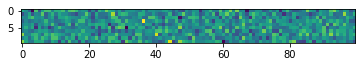

In [34]:
plt.imshow(noise)

In [35]:
images = generator(noise)

In [36]:
images.shape #ten imgs, 28x28 each

TensorShape([10, 28, 28, 1])

In [45]:
example_image = images[9].numpy().reshape(28,28)

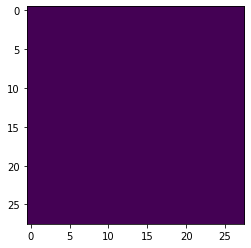

In [46]:
plt.imshow(example_image)